# Linear regression

We'll solve the problem of linear regression in a few different ways:

- First we'll use `sklearn` to find the answer we're looking for
- Analytic solution for univariate problems
- The normal equation of linear algebra
- Singular value decomposition (this is what `sklearn` actually uses)
- Batch gradient descent
- Stochastic gradient descent
- Bayesian linear regression: maximum a posteriori

---

## Load some data

We'll use our 'rocks' data:

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_simple.csv')

df.head()

,Vp,Vs,rho,Lithology
0,3045.6,1595.7,2.109121,sandstone
1,3000.6,1517.1,2.090342,sandstone
2,3363.6,2041.5,2.131990,sandstone
3,3195.3,1606.2,2.184939,sandstone
4,4237.5,2448.6,2.472231,sandstone


Let's try to predict `Vs` from `Vp`. Later, you can try adding `Rho_n` as another feature to see how you can use these algorithms on multivariate data.

In [2]:
data = df[['Vp', 'Vs']].values

<h3>Random data</h3>

<p>If you prefer, you can make a dataset from a multivariate normal distribution, so we can control the statistics of the features and target.</p>

<b>To do this, run the following code:</b>

<pre>
import numpy as np

num_samples = 100

# The desired mean values of the sample.
mu = np.array([5.0, 5.0, 10.0])

# The desired covariance matrix.
r = np.array([
        [  2.00,  0.00, -2.00],
        [  0.00,  2.00,  2.00],
        [ -2.00,  2.00,  4.00]
    ])

# Generate the random samples.
data = np.random.multivariate_normal(mu, r, size=num_samples)
</pre>

## Make `X` and `y`

We can visualize the data:

<AxesSubplot:xlabel='x', ylabel='y'>

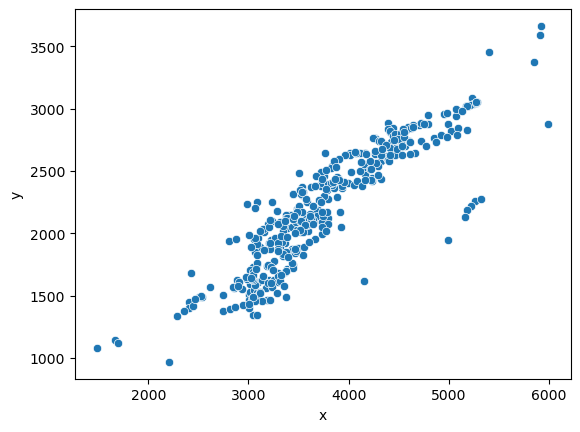

In [3]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data, columns=['x', 'y'])

sns.scatterplot(data=df, x='x', y='y')

In [4]:
# Univariate case
X = data[:, 0:1]
y = data[:, 1]

print(X.shape, y.shape)

(400, 1) (400,)


In the multivariate case, we should always standardize the data; in the univariate case, there's usually no need, but in my experience, gradient descent does not perform well on unscaled data, so let's standardize first.

In [5]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## Draw a line

If you accept that we want the model that minimizes the mean squared error on the estimates, then you could try to manually fit a line that does this. You could print out the figure above and draw a line with a ruler, then calculate the slope (`w`) and the intercept (`b`).

Or you could use this widget:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

X_plt = np.arange(-3, 3, 0.1)
y_plt_manual = None

@interact(w=(-1000, 1000, 50), b=(0, 3000, 50))
def draw(w, b):
    global y_plt_manual  # So we can inspect it later.
    y_plt_manual = w*X_plt + b
    plt.scatter(X[:, 0], y)
    plt.plot(X_plt, y_plt_manual, color='orange')
    plt.show()

interactive(children=(IntSlider(value=0, description='w', max=1000, min=-1000, step=50), IntSlider(value=1500,…

## Solve with `sklearn`

Okay, but we have a computer, and we'd like something more robust, more reproducible, and less error prone. 

We love and trust `sklearn` so let's start with that as a sort of baseline.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)
print(f"MSE: {mean_squared_error(y, y_pred):.3f}\n")

w, b = model.coef_, model.intercept_

print(f"w = {w[0].item():.3f}\nb = {b:.3f}")

MSE: 46591.207

w = 431.562
b = 2188.855


And plot the data with the model we just discovered:

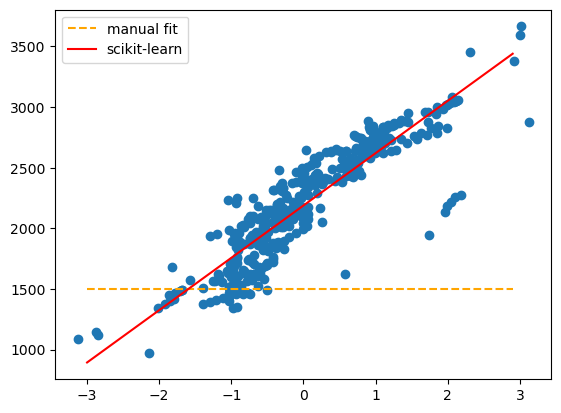

In [8]:
y_plt_sk = model.coef_[0]*X_plt + model.intercept_

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_manual, color='orange', ls='--', label='manual fit')
plt.plot(X_plt, y_plt_sk, color='r', label='scikit-learn')
plt.legend()
plt.show()

## Closed form solution: algebra

For the univariate case, it's possible to derive equations for the parameters based on the partial derivatives of the loss; the equations have a unique solution (equation 18.3 in _Artificial Intelligence: A Modern Approach_ (3rd ed.) by Stuart Russell and Peter Norvig, Pearson, 2016):

$$ w = \frac{N \Sigma x_i y_i - \Sigma x_i \Sigma y_i}{N \Sigma x^2_i - (\Sigma x_i)^2} $$

$$ b = \frac{1}{N} \Sigma y_i - w \Sigma x_i $$

This is not too hard to compute in NumPy:

In [9]:
N = X.shape[0]
x = X[:, 0]

w = (N * (x*y).sum() - x.sum() * y.sum()) / (N * (x**2).sum() - x.sum()**2)

b = (y.sum() - w * x.sum()) / N

w, b

(431.5616664063004, 2188.8553005275007)

These match the numbers we got from `sklearn`, so there's not much point in drawing the plot again.

## Closed form solution: linear algebra

There's another analytic way to solve this equation that extends more easily to multivariate datasets (i.e. where `X` has more than one column). In principle, this is much faster and easier to do than gradient descent. In practice, it might be expensive or even intractable, e.g. on very large datasets, or with custom loss functions.

We need the so-called [**normal equation**](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations):

$$ \mathbf{y} = \mathbf{w}\mathbf{X} $$

We want the weights $\mathbf{w}$, so:

$$ \mathbf{w} = \mathbf{X}^{-1}\mathbf{y} $$

The catch is that $\mathbf{X}^{-1}$ may not be possible to compute, so we have to use [the pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of `X`, aka Moore&ndash;Penrose inverse. In our case:

$$ \mathbf{X}^{-1} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top $$

This approach is easier if we add a column of 1's to `X`, and concatenate the weights `w` with the bias `b`, so that we have a single data matrix and a single weight vector. This is sometimes called the **design matrix**:

In [10]:
N = X.shape[0]
X_ = np.c_[X, np.ones((N, 1))]

X_[:5]

array([[-0.97030224,  1.        ],
       [-1.03277819,  1.        ],
       [-0.52880548,  1.        ],
       [-0.76246555,  1.        ],
       [ 0.68447761,  1.        ]])

That [`np.c_`](https://numpy.org/doc/stable/reference/generated/numpy.c_.html) implements a concatenation trick. You can also use `np.hstack`.

Now we can implement the 'naive' version of the normal equation:

In [11]:
np.set_printoptions(suppress=True)

In [12]:
import numpy.linalg as la

X_inv = la.inv(X_.T @ X_) @ X_.T  # The 'pseudoinverse' of X.

X_inv @ y

array([ 431.56166641, 2188.85530053])

The same numbers again: we solved it! Pretty cool. But it can be slow for large datasets and besides it won't always work &mdash; so we need a more robust method.

We could use `numpy.linalg.pinv()` to get the pseudoinverse directly...

In [13]:
la.pinv(X_) @ y

array([ 431.56166641, 2188.85530053])

... but that's no fun. Let's see what this, and `sklearn` are using internally.

## Singular value decomposition

The above method is computationally expensive (i.e. slow) and won't always work.

Internally, `sklearn` uses `scipy.linalg.lstsq()` and this, in turn, uses one of three algorithms in the Fortran library LAPACK (which NumPy depends on): `gelsd`, `gelsy` and `gelss`. Of these, `gelsd` and `gelss` use the singular value decomposition of our matrix `X_`.

In brief, we can solve:

$$ \mathbf{w} = \mathbf{V} \mathbf{\Sigma}^{+} \mathbf{U}^\top \, \mathbf{y} $$

[Read more about this.](https://towardsdatascience.com/why-gradient-descent-and-normal-equation-are-bad-for-linear-regression-928f8b32fa4f)



Here's how this equation looks in NumPy; the only really tricky part is forming $\Sigma^{+}$:

In [14]:
U, sigma, VT = la.svd(X_, full_matrices=False)

VT.T @ np.diag(1/sigma).T @ U.T @ y

array([ 431.56166641, 2188.85530053])

---

## Gradient descent

Let's solve the problem using gradient descent. We clearly don't _need_ gradient descent here, but it's a good optimization method to know about because most problems don't have closed form solutions. In general, if we can form the derivative of the cost function (i.e. it is 'differentiable'), we can use this method.

So in order to optimize the weights using gradient descent, we need to know the **gradient** of the **cost function**. The cost $C$ over $N$ samples is given by:

$$ C = \frac{1}{N} \sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2 $$

where the estimate $\hat{\mathbf{y}}$ is given by the matrix product of the weights $\theta$ and the 'augmented' data $\bar{\mathbf{X}}$ (the data plus an extra column of ones):

$$ \hat{\mathbf{y}} = \mathbf{w} \mathbf{X} + b = \theta \bar{\mathbf{X}} $$

Using this 'combined' weight matrix is easier than dealing with the weights and bias term separately. Note that $\theta$ is a vector, although it's displayed with an italic character here.

#### Chain rule

There are 2 functions here: the expression for $C$ and the one for $\hat{\mathbf{y}}$. The chain rule tells us how to differentiate a function of a function:

$$ \frac{\mathrm{d}}{\mathrm{d}x}\big[ f(g(x)) \big] = f^\prime(g(x))\ \times\ g^\prime(x) $$

Therefore the gradient $g$ is given by:

$$ g = \frac{\mathrm{d}C}{\mathrm{d}\theta} = \frac{\mathrm{d}C}{\mathrm{d}\hat{\mathbf{y}}}\ \times\ \frac{\mathrm{d}\hat{\mathbf{y}}}{\mathrm{d}\theta} $$

So our problem now looks like this:

$$ g = \frac{2}{N}\sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)\ \times\ -\mathbf{X}_i $$

so if the error $\mathbf{e} = (\mathbf{y} - \hat{\mathbf{y}})$ then:

$$ g = -\frac{2}{N}\sum_{i=0}^{N} \mathbf{e}_i \mathbf{X}_i $$

In [15]:
alpha = 1e-3   # This must be tuned to the scale of the input.
epochs = 5_000

# Initialize.
cost_history = []
theta = np.zeros(X_.shape[1])

for i in range(epochs):
    # Make estimate with current weights.
    y_hat = theta @ X_.T
    
    # Compute error and cost.
    err = y - y_hat
    cost = np.sum(err**2) / N
    cost_history.append(cost)
    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")
        
    # Compute gradients (one for each feature).
    grad = (-2/N) * np.sum(err[:, None] * X_, axis=0)
    
    # Adjust weights.
    theta -= alpha * grad

print(f"{'end':>8s} {cost:.3f}")

       0 5023924.206
     500 718852.312
    1000 137389.832
    1500 58854.880
    2000 48247.594
    2500 46814.926
    3000 46621.424
    3500 46595.288
    4000 46591.758
    4500 46591.282
     end 46591.217


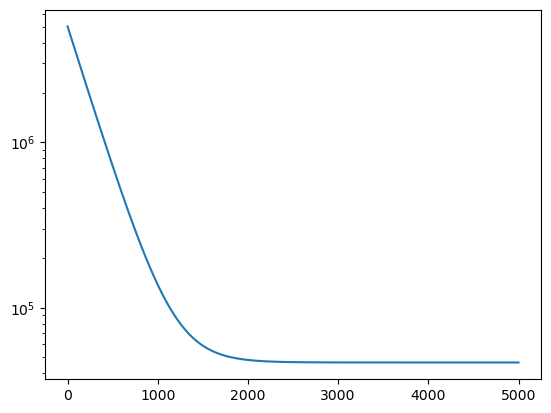

In [16]:
plt.plot(cost_history)
plt.yscale('log')

Let's make sure it's similar to what we got before, which was

In [17]:
# With SVD...
w, b

(431.5616664063004, 2188.8553005275007)

In [18]:
# With gradient descent...
theta

array([ 431.54226875, 2188.75691675])

## Stochastic gradient descent

Here, we're computing the cost over the entire dataset. In practice, this might not be possible, especially on high-dimensional datasets. We can reduce the computational burden by computing the cost over smaller 'batches'. This is known as 'stochastic gradient descent'. 

We'll also shuffle the data before each epoch (one epoch is one pass through the entire dataset). This helps to avoid getting stuck in a local minimum, because every time we take a step on the cost surface, we're on a slightly different version of the surface.

In [19]:
alpha = 1e-3
epochs = 500
batch_size = 50

splits = np.arange(batch_size, N, batch_size)
idx = np.arange(N)

# Initialize.
cost_history = []
theta = np.random.random(X_.shape[1])

for i in range(epochs):
    
    # Shuffle the data.
    np.random.shuffle(idx)
    X_shuffle = X_[idx]
    y_shuffle = y[idx]
    X_batches = np.split(X_shuffle, splits)
    y_batches = np.split(y_shuffle, splits)

    for j, (X_batch, y_batch) in enumerate(zip(X_batches, y_batches)):

        # Make estimate with current weights.
        y_hat = theta @ X_batch.T

        # Compute error and (once per epoch) cost.
        err = y_batch - y_hat
        
        if j == 0:
            cost = np.sum(err**2) / batch_size
            cost_history.append(cost)

        # Compute gradients (one for each feature).
        grad = (-2/batch_size) * np.sum(err[:, None] * X_batch, axis=0)

        # Adjust weights.
        theta -= alpha * grad

    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")

print(f"{'end':>8s} {cost:.3f}")

       0 5443700.307
      50 1070386.522
     100 306413.320
     150 90981.688
     200 43811.893
     250 49816.429
     300 61162.710
     350 36707.680
     400 33600.475
     450 33864.346
     end 76454.142


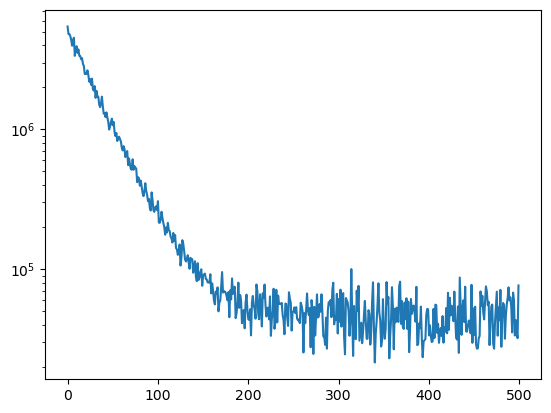

In [20]:
plt.plot(cost_history)
plt.yscale('log')

Notice that this converges much faster than using the entire dataset: only 500 epochs, compared to 5000.

In [21]:
theta

array([ 431.41394236, 2188.12196509])

This compares well with what we got from the SVD method above:

In [22]:
w, b

(431.5616664063004, 2188.8553005275007)

And let's check the new parameters against the previous solution:

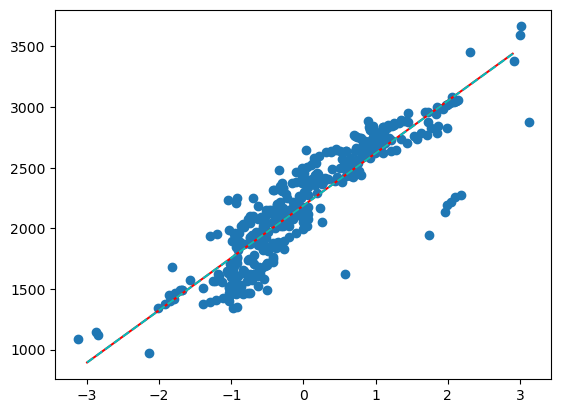

In [23]:
# Two parameters:
w_sgd, b_sgd = theta

y_plt = w_sgd*X_plt + b_sgd

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')  # regression line
plt.plot(X_plt, y_plt, '--', color='c')  # regression line
plt.show()

It matches!

## Compare with `sklearn`'s own SGD regressor

Let's try with [`sklearn.linear_model.SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), which implements a generic SGD regressor that can solve linear regression (with or without regularization).

In [24]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha=0).fit(X, y)  # Turn off regularization.

y_pred = model.predict(X)
print(f"MSE: {mean_squared_error(y, y_pred):.3f}\n")

(w,), (b, ) = model.coef_, model.intercept_
print(f"w0 = {w:.3f}\nb = {b:.3f}")

MSE: 46591.790

w0 = 431.048
b = 2188.290


It matches too!

## Bayesian linear regression

In general, Bayesian methods try to account for uncertainty by treating everything as a distribution. Correspondingly, instead of finding _best fit_ parameters, a Bayesian approach will yield _posterior distributions_ for our parameters.

Broadly, there are two Bayesian approaches: "maximum likelihood estimation" (MLE), which is broadly equivalent to ordinary least squares (under the assumption that the data contains Gaussian noise), and "maximum a posteriori" (MAP). These approach the problem in different ways:

- MLE: How likely is the data, given the parameters?
- MAP: How likely are the parameters, given the data?

We'll apply MAP here, guided by Chris Bishop's book, _Pattern Recognition and Machine Learning_ (Springer, 2006, [PDF](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)), and by [this blog post](https://brunomaga.github.io/Bayesian-Linear-Regression).

In [25]:
N, M = X_.shape
alpha = 1  # Init.
beta = 1   # Initialize as 1/variance.
mean = np.zeros(M)
lamda = 1e-6  # Regularization.

snaps = []  # Capture the first guess in each loop.

for iteration in range(2):
    weights = []
    S_0_inv = np.identity(M) / alpha
    for i, (xi, yi) in enumerate(zip(X_, y)):

        # Update the (inverse) covariance, Bishop's equation 3.51.
        S_N_inv = S_0_inv + beta * np.outer(xi, xi)

        # Update the mean, Bishop's equation 3.50.
        S_N = la.inv(S_N_inv)
        mean = S_N @ (S_0_inv @ mean + beta * xi * yi)
        S_0_inv = S_N_inv

        weights.append((mean, S_N_inv))
        
        # Snapshot early iterations for plotting later.
        if iteration == 0 and i % 5 == 0:
            snaps.append((i, ) + weights[-1])

# Final coefficients:
weights[-1][0]

array([ 431.55898258, 2188.84168833])

As we step over the early data points, there are dramatic updates to the weights. 

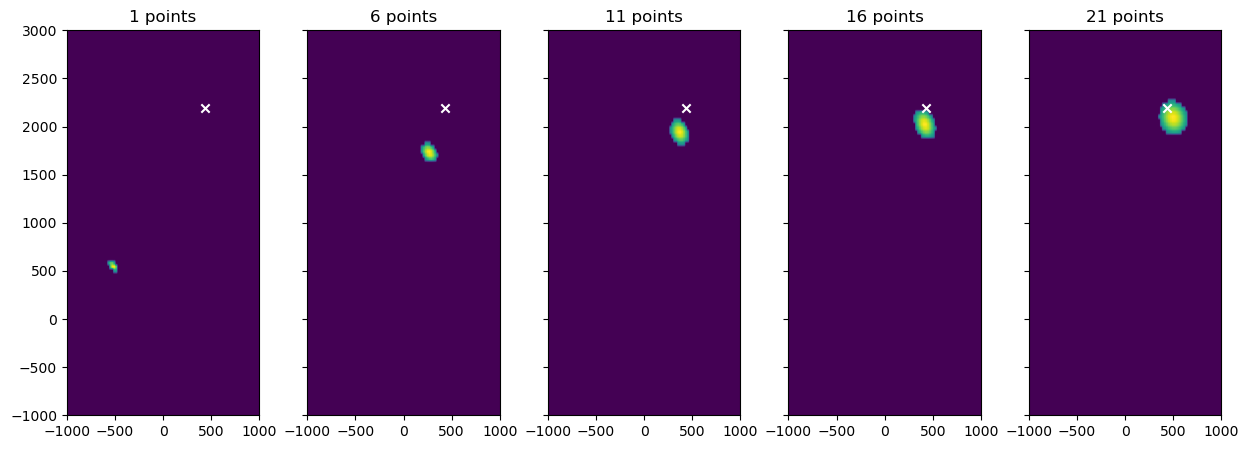

In [26]:
from scipy import stats

fig, axs = plt.subplots(ncols=5, sharey=True, figsize=(15, 5))

for ax, (i, mean, S_N_inv) in zip(axs, snaps[:5]):

    S_N = np.linalg.inv(S_N_inv)
    dist = stats.multivariate_normal(mean=mean, cov=S_N_inv)

    w = np.linspace(-1000, 1000, 100)
    b = np.linspace(-1000, 3000, 100)
    W = np.dstack(np.meshgrid(w, b))
    pdf = dist.pdf(W)

    ax.imshow(pdf**0.001, origin='lower', extent=[-1000, 1000, -1000, 3000])
    ax.scatter(*weights[-1][0], marker='x', c='w')
    ax.set_title(f'{i+1} points')

The resulting model is comparable to the one we found with `sklearn`:

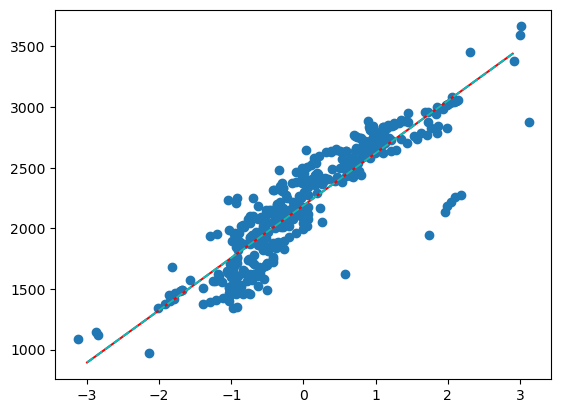

In [27]:
w, b = weights[-1][0]
y_plt = w*X_plt + b

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')  # regression line
plt.plot(X_plt, y_plt, '--', color='c')  # regression line
plt.show()

They match! Nice.

## Simulated annealing

From [this Cross Validated post](https://stats.stackexchange.com/a/340687/74162):

> Simulated annealing's fundamental mechanism is to compare the current state with a proposed state, then (probabilistically) decide whether to move to the proposed state or not.

The same post has some R code, translated to Python below. It's not very sophisticated (e.g., no guesstimate of the required `scale` hyperparameter, and no early stopping), but it gets the job done.

In [36]:
from scipy.stats import t


def mean_squared_error(X, y, w):
    """Mean square error for a given guess."""
    degrees_of_freedom = len(y)
    y_hat = X @ w.reshape(-1, 1)
    return np.sum((y - y_hat.T)**2) / degrees_of_freedom


def simulated_annealing(X, y, scale=1, max_iter=1000, step=0.05):
    """
    Implements simple simulated annealing algorithm.
    Starting from: https://stats.stackexchange.com/a/340687/74162
    """
    # Initialize everything.
    rng = np.random.default_rng(42)
    k_best = 1
    temp = 1
    w = w_best = np.ones(X.shape[-1])
    mse = mse_best = mean_squared_error(X, y, w)

    for k in range(max_iter):
        
        # Update the scaling factor to control learning rate.
        temp *= (1 - step)
        
        # Make and score a new proposal.
        w_prop = t.rvs(size=2, df=3, loc=w, scale=scale)
        mse_prop = mean_squared_error(X, y, w_prop)
        test = np.exp(-(mse_prop - mse) / temp)
        
        # Use the test, and a random element, to decide
        # if we're updating or not.
        if (mse_prop < mse) or (rng.uniform(0, 1) < test):
            w = w_prop
            mse = mse_prop
            
            if mse_prop < mse_best:
                w_best = w
                mse_best = mse

    return w_best

In [37]:
simulated_annealing(X_, y, scale=10, max_iter=2000)

/tmp/ipykernel_146921/3801482789.py:31: RuntimeWarning: overflow encountered in exp
  test = np.exp(-(mse_prop - mse) / temp)


array([ 431.41380377, 2188.61298574])

Ah, the familiar parameters, very cool.

## More...

- You should know about [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), it's fast.
- Take a look at [`statsmodels`](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), it's fast.
- Check out [`pylops`](https://pylops.readthedocs.io/en/latest/gallery/plot_linearregr.html).


----

&copy; 2023 Matt Hall / [https://github.com/kwinkunks](https://github.com/kwinkunks) / MIT licence